# Calculate the SHDOM Input

In this version I calculate the solar flux input to the SHDOM. In this version I detail the results of the talk I did with Yoav.

In [1]:
from __future__ import division
%matplotlib inline
import CameraNetwork.sunphotometer as spm
import cPickle
import datetime
from dateutil import parser
import math
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16.0, 16.0)
import numpy as np
import os
import pandas as pd
idx = pd.IndexSlice
from pyspectral.solar import (SolarIrradianceSpectrum,
                              TOTAL_IRRADIANCE_SPECTRUM_2000ASTM)
from scipy.optimize import curve_fit
from scipy import constants

/home/amitibo/code/cameranetwork/CameraNetwork/transformation_matrices.py:1934: UserWarning: failed to import module _transformations
  warnings.warn("failed to import module %s" % name)


## Load the Camera Quantum Efficiency Curves

In [2]:
base_path = r"../../data/camera_QE"
blue_df = pd.read_csv(os.path.join(base_path, "UI-1551LE-C_QE-blue auto.csv"), names=["wavelength", "QE"])
green_df = pd.read_csv(os.path.join(base_path, "UI-1551LE-C_QE-green auto.csv"), names=["wavelength", "QE"])
red_df = pd.read_csv(os.path.join(base_path, "UI-1551LE-C_QE-red auto.csv"), names=["wavelength", "QE"])

max_wavelength = 700

blue_df = blue_df[blue_df["wavelength"] < max_wavelength]
green_df = green_df[green_df["wavelength"] < max_wavelength]
red_df = red_df[red_df["wavelength"] < max_wavelength]

## Sepctral Data

Total Top of Atmosphere (TOA) Solar Irradiance Spectrum Wavelength is in units of microns (10^-6 m). The spectral Irradiance in the file TOTAL_IRRADIANCE_SPECTRUM_2000ASTM is in units of W/m^2/micron

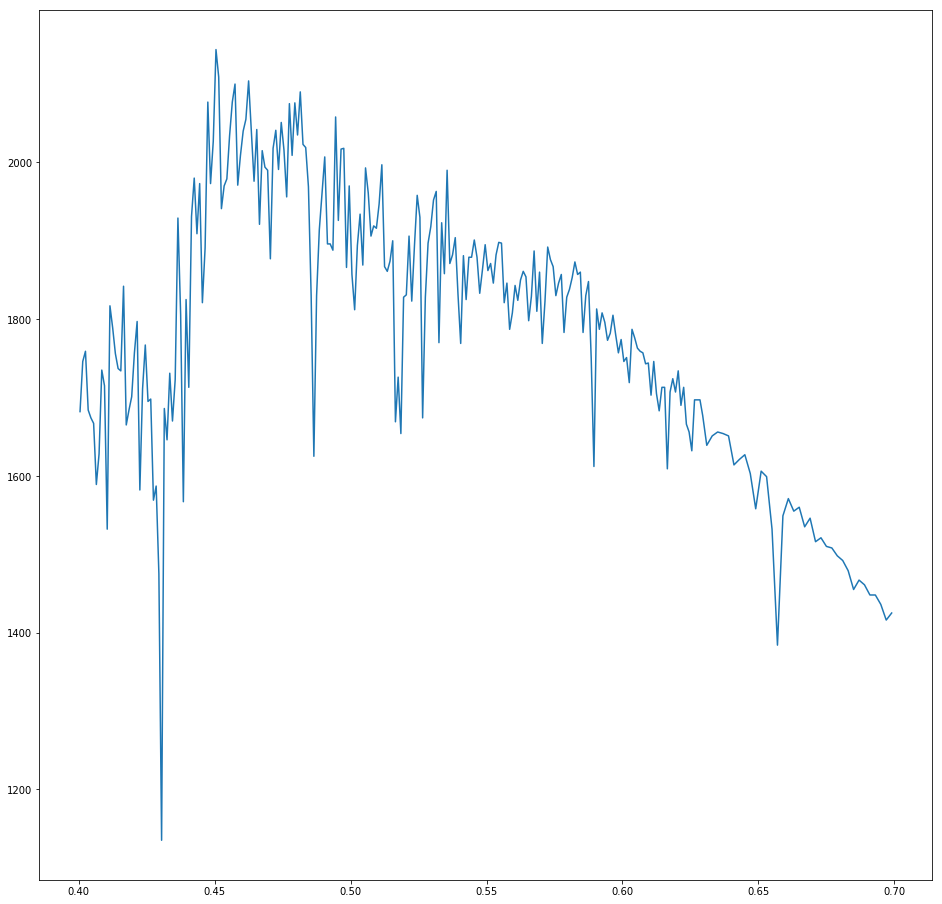

In [3]:
solar_irr = \
    SolarIrradianceSpectrum(TOTAL_IRRADIANCE_SPECTRUM_2000ASTM, dlambda=0.005)
solar_df = pd.DataFrame(dict(wavelength=solar_irr.wavelength, irradiance=solar_irr.irradiance))
solar_df = solar_df[(solar_df["wavelength"]>0.400)&(solar_df["wavelength"]<0.700)]
plt.plot(solar_df["wavelength"], solar_df["irradiance"])

### Calculate the Flux

We use the Green channel in the pyshdom.

Here I calculate:

$\int_{\lambda} \, \lambda \, \text{QE}_{\lambda} \, L^{\text{TOA}}_{\lambda} \, d\lambda$

Note that the units here are as follows:

$L^{\text{TOA}}$ is given in $\frac{W}{m^2 \, \mu m}$

$\text{QE}_{\lambda}$ is unitless.

$\lambda$ is given in $\mu m$

So $\int_{\lambda} \, \lambda \, \text{QE}_{\lambda} \, L^{\text{TOA}}_{\lambda} \, d\lambda$ is $\int_{\lambda} [\mu m] \, [\frac{W}{m^2 \, \mu m}] \, d\lambda$. Note that the integral by $\lambda$ multiplies the integrand by $[\mu m]$. So the total units are $[\frac{\mu m \, W}{m^2}]$.

<!---
$h$ is given in $J \cdot s$

$c$ is given in $\frac{m}{s}$ so we have to multiply it by $10^6$ to get it in $\mu m$

So $\int_{\lambda} \frac{\lambda}{h \, c} \, \text{QE}_{\lambda} \, L^{\text{TOA}}_{\lambda} \, d\lambda$ is $\int_{\lambda} \frac{[\mu m]}{[J \cdot s] \, [\frac{\mu m}{s}]} \, [\frac{W}{m^2 \, \mu m}] \, d\lambda$. Note that the integral by $\lambda$ multiplies the integrand by $[\mu m]$. So the total units are $[\frac{1}{m^2 \, s}]$.
-->

### For Red Channel

In [7]:
TEST_RSR = {}
TEST_RSR['det-1'] = dict(
    wavelength=red_df["wavelength"].values/1000,
    response=red_df["QE"]/100 * red_df["wavelength"].values/1000
    )

In [8]:
solar_irr.inband_solarflux(TEST_RSR, scale=1.0)

42.769359152090637

### For Green Channel

In [9]:
TEST_RSR = {}
TEST_RSR['det-1'] = dict(
    wavelength=green_df["wavelength"].values/1000,
    response=green_df["QE"]/100 * green_df["wavelength"].values/1000
    )

In [10]:
solar_irr.inband_solarflux(TEST_RSR, scale=1.0)

43.631256957684251

### For Blue Channel

In [11]:
TEST_RSR = {}
TEST_RSR['det-1'] = dict(
    wavelength=blue_df["wavelength"].values/1000,
    response=blue_df["QE"]/100 * blue_df["wavelength"].values/1000
    )

In [12]:
solar_irr.inband_solarflux(TEST_RSR, scale=1.0)

40.939320304438596

## Conversion Between PySpectral Units (SHDOM) to Sunphotometer

The flux given by pyspectral is in the following units: $[\frac{W}{m^2 \, \mu m}]$

The units of the Sun Photometer are: $[\frac{\mu W}{cm^2 \, \omega \, nm}]$

So to bridge these usits, the SHDOM input should be multiplied by: $\frac{10^6}{(10^2)^2 \, 10^3} = 0.1$


# Old Stuff

In [37]:
TEST_RSR = {}
TEST_RSR['det-1'] = dict(
    wavelength=green_df["wavelength"].values/1000,
    response=green_df["QE"]/100 * green_df["wavelength"].values/1000 * 1e-6 / (constants.h * constants.c)
    )

In [38]:
solar_irr.inband_solarflux(TEST_RSR, scale=1.0)

2.1964483715973553e+20

## Load the Sunphotometer Single Scattering Albedo data

In [92]:
df = spm.parseSunPhotoMeter(r'..\..\data\aeronet\2017_04\170422_170422_Technion_Haifa_IL.ssa')
df.head()

,Julian_Day,SSA441-T,SSA674-T,SSA871-T,SSA1020-T,last_processing_date(mm/dd/yyyy),alm_type,solar_zenith_angle_for_1020nm_scan,sky_error,sun_error,...,scat_angle_1020(>=3.2to6),scat_angle_1020(>=6to30),scat_angle_1020(>=30to80),scat_angle_1020(>=80),albedo_440,albedo_675,albedo_870,albedo-1020,average_solar_zenith_angle_for_flux_calculation,DATA_TYPE
Date(dd-mm-yyyy)_Time(hh:mm:ss),,,,,,,,,,,,,,,,,,,,,
2017-04-22 04:19:15,112.180035,0.8797,0.9247,0.9302,0.9372,26/04/2017,0,74.848008,3.874145,0.005485,...,4,10,4,5,0.05228,0.14077,0.33591,0.33844,74.225759,Level_1.5
2017-04-22 04:43:21,112.196771,0.8921,0.9365,0.9427,0.9492,26/04/2017,0,69.803218,4.782619,0.007024,...,4,10,5,5,0.05017,0.13461,0.31785,0.31683,69.078535,Level_1.5
2017-04-22 05:33:17,112.231447,0.9122,0.9488,0.9562,0.9609,26/04/2017,0,59.326484,4.584084,0.011117,...,3,10,6,4,0.04670,0.12384,0.28855,0.28927,58.718886,Level_1.5
2017-04-22 06:40:30,112.278125,0.8948,0.9252,0.9311,0.9375,26/04/2017,0,45.449479,2.974542,0.016758,...,4,10,5,3,0.04430,0.11600,0.26678,0.26684,44.901980,Level_1.5
2017-04-22 12:40:33,112.528160,0.8756,0.9212,0.9334,0.9426,26/04/2017,0,46.263609,4.767822,0.018390,...,2,10,8,3,0.04462,0.11697,0.26901,0.26782,46.847872,Level_1.5


## Steradian per Pixel

There are $2 \pi$ steradians in a half sphere. There are $\pi \dot r^2$ pixles in an image (where $r$ is the half length/width of an image).

In [96]:
r = 301/2.
(2 * math.pi) / (math.pi * r**2)

8.829924614518602e-05